# Analysis of Airport Delay Data

# Problem Statement

In this project I seek to produce a explanatory measure of the delays in flights at U.S. airports and produce an explanatory model for that measure.  Using PCA, I will show that a variety of data regarding delays in departures, in-flight, and arrivals can be condensed into a single scalar metric which encapsulates over half of the variance in the data set while being human-readable.  I also attempt to fit models to predict this based on available location, flight volume, and cancellation data, and I show that these models have little predictive power, indicating that the available data is insufficient to effectively predict the degress of delay at a given airport.

## Required Python Libraries

In [2]:
import pandas as pd 
import matplotlib as plt
import numpy as np
import sklearn as sk 
import seaborn as sns
from itertools import combinations

import sqlalchemy
import psycopg2 as pg
from pandas.io import sql

from IPython.display import display

%matplotlib inline

In [3]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Load Data Set

In [4]:
airports = pd.read_csv("assets/airports.csv")
airports.dropna(inplace=True)
airports[:3]

,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
2,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,Airport,ASO,#NAME?,PONCE,PR,Public Use,18.008306,-66.563028,Yes
3,2879.0,VQS,ANTONIO RIVERA RODRIGUEZ,Aeropuerto Antonio Rivera Rodr�guez,Airport,ASO,#NAME?,ISLA DE VIEQUES,PR,Public Use,18.134811,-65.493617,Yes


In [5]:
operations = pd.read_csv("assets/airport_operations.csv")
operations.dropna(inplace=True) 
operations[:3]

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82


In [6]:
cancellations = pd.read_csv("assets/airport_cancellations.csv")
cancellations.dropna(inplace=True) 
cancellations[:3]

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0


## Create a Postgres Database

#### Join the tables

I perform an inner join on all three tables using the airport code.

In [7]:
joined = pd.merge(airports, operations, left_on="LocID", right_on="airport", how="inner").drop("LocID", axis=1)
joined = pd.merge(joined, cancellations, left_on="airport", right_on="Airport", how="inner").drop("Airport", axis=1)

#### Load the joined table into the sql database

The table name is "airport_data_joined"

In [8]:
engine = sqlalchemy.create_engine("postgres://{}:{}@localhost:5432".format("dsanford",""))
conn = engine.connect()

In [9]:
conn = engine.connect()
joined.to_sql('airport_data_joined',con=conn,if_exists='replace',index=False)
conn.close()

#### Perform a test load from the database

This table is not used below because the SQL part was written after the rest of the analysis.

In [10]:
conn = engine.connect()
test_table = pd.read_sql("SELECT * FROM airport_data_joined",con=conn)
test_table.head(3)

,Key,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,...,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,2885.0,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,...,12.43,1.88,0.79,3.39,12.28,2004.0,330.0,289.0,55.0,28.0
1,2885.0,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,...,12.43,1.88,0.79,3.39,12.28,2005.0,315.0,282.0,64.0,36.0
2,2885.0,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,...,12.43,1.88,0.79,3.39,12.28,2006.0,257.0,233.0,63.0,44.0


# Exploratory Data Analysis

### Pair Plots of Operations Data

In the pair plot, I am primarily looking for outliers.  There is an obvious outlying cluster of points with very low percentages for on-time arrivals and departures, both below 40%, which corresponds to a small number of airports.  The rest of the data set is clustered at higher values of both.  In contrast, there does not seem to be any strong dependence on year; the lower percentage tails for on-time flights are different for different years, and there is some indication of movement of the mean, but any effect appears to be non-linear and thus difficult to capture.
Moreover, there (unsurprisingly) appears to be some correlation between the total flight volume and airport, but little correlation between flight volume and year.

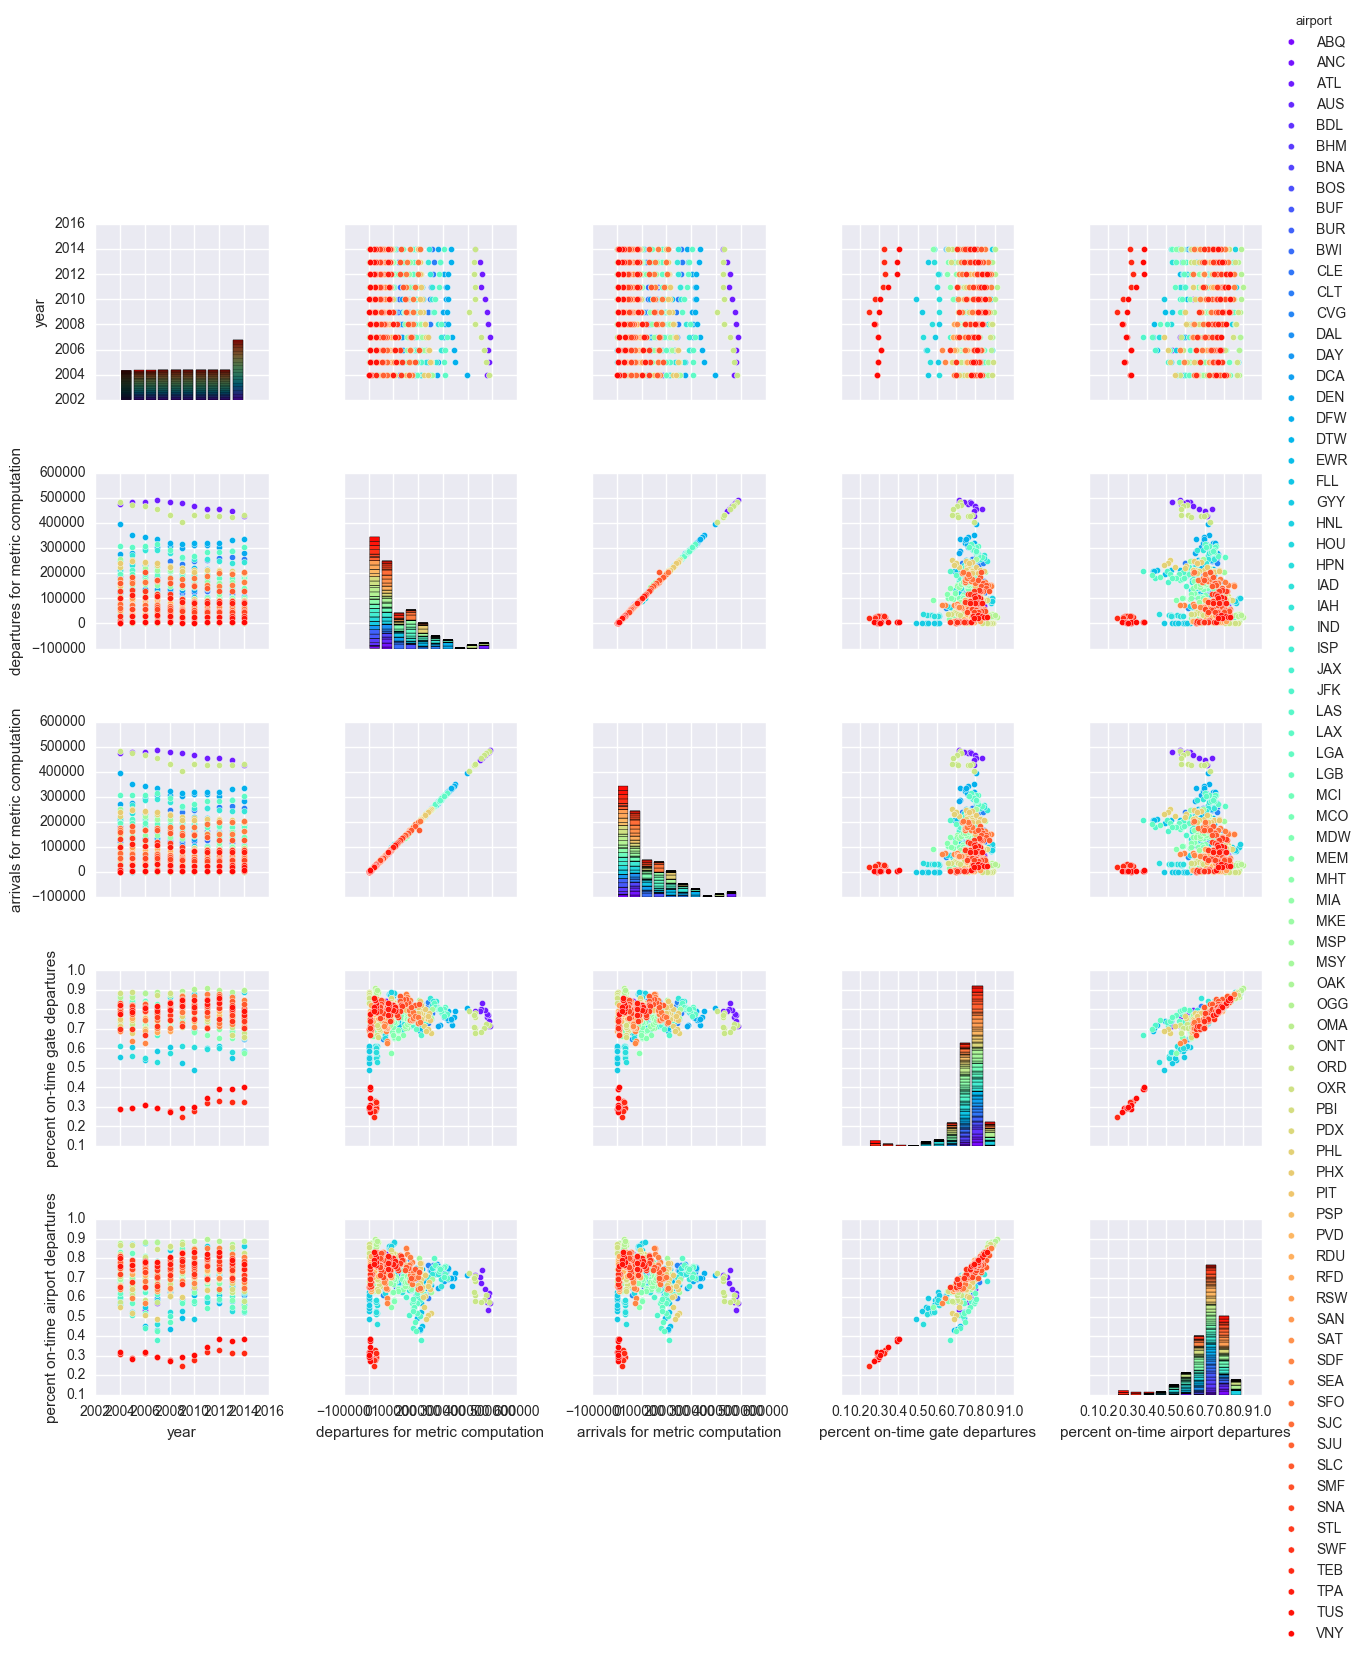

In [11]:
sns.pairplot(operations[["airport","year","departures for metric computation",
                         "arrivals for metric computation",
                         "percent on-time gate departures","percent on-time airport departures"]],
             hue="airport", palette = "rainbow")

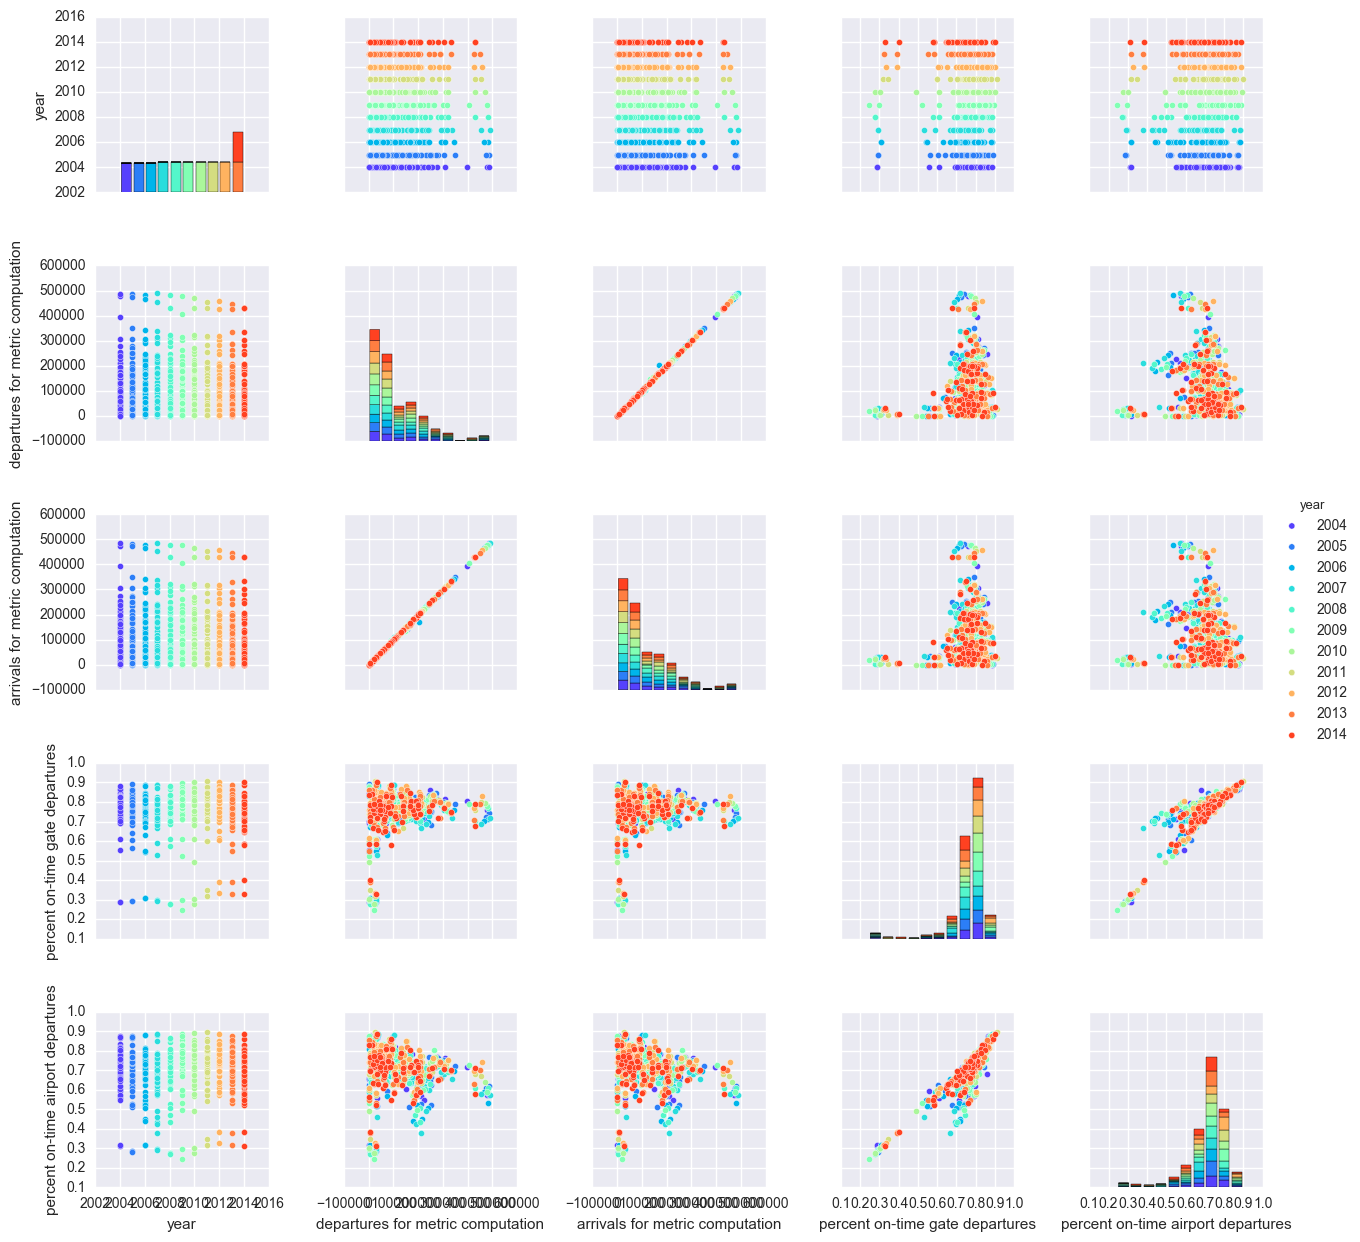

In [12]:
sns.pairplot(operations[["airport","year","departures for metric computation",
                         "arrivals for metric computation",
                         "percent on-time gate departures","percent on-time airport departures"]],
             hue="year", palette = "rainbow")

### Pair Plots of Cancellation Data

Like the operations data, the cancellation data also shows some sign of clustering based on airport but little based on year.  Note that the data presented represents the total volume of cancellations, not a rate relative to total volume, so identifying outliers in this data set would be difficult.

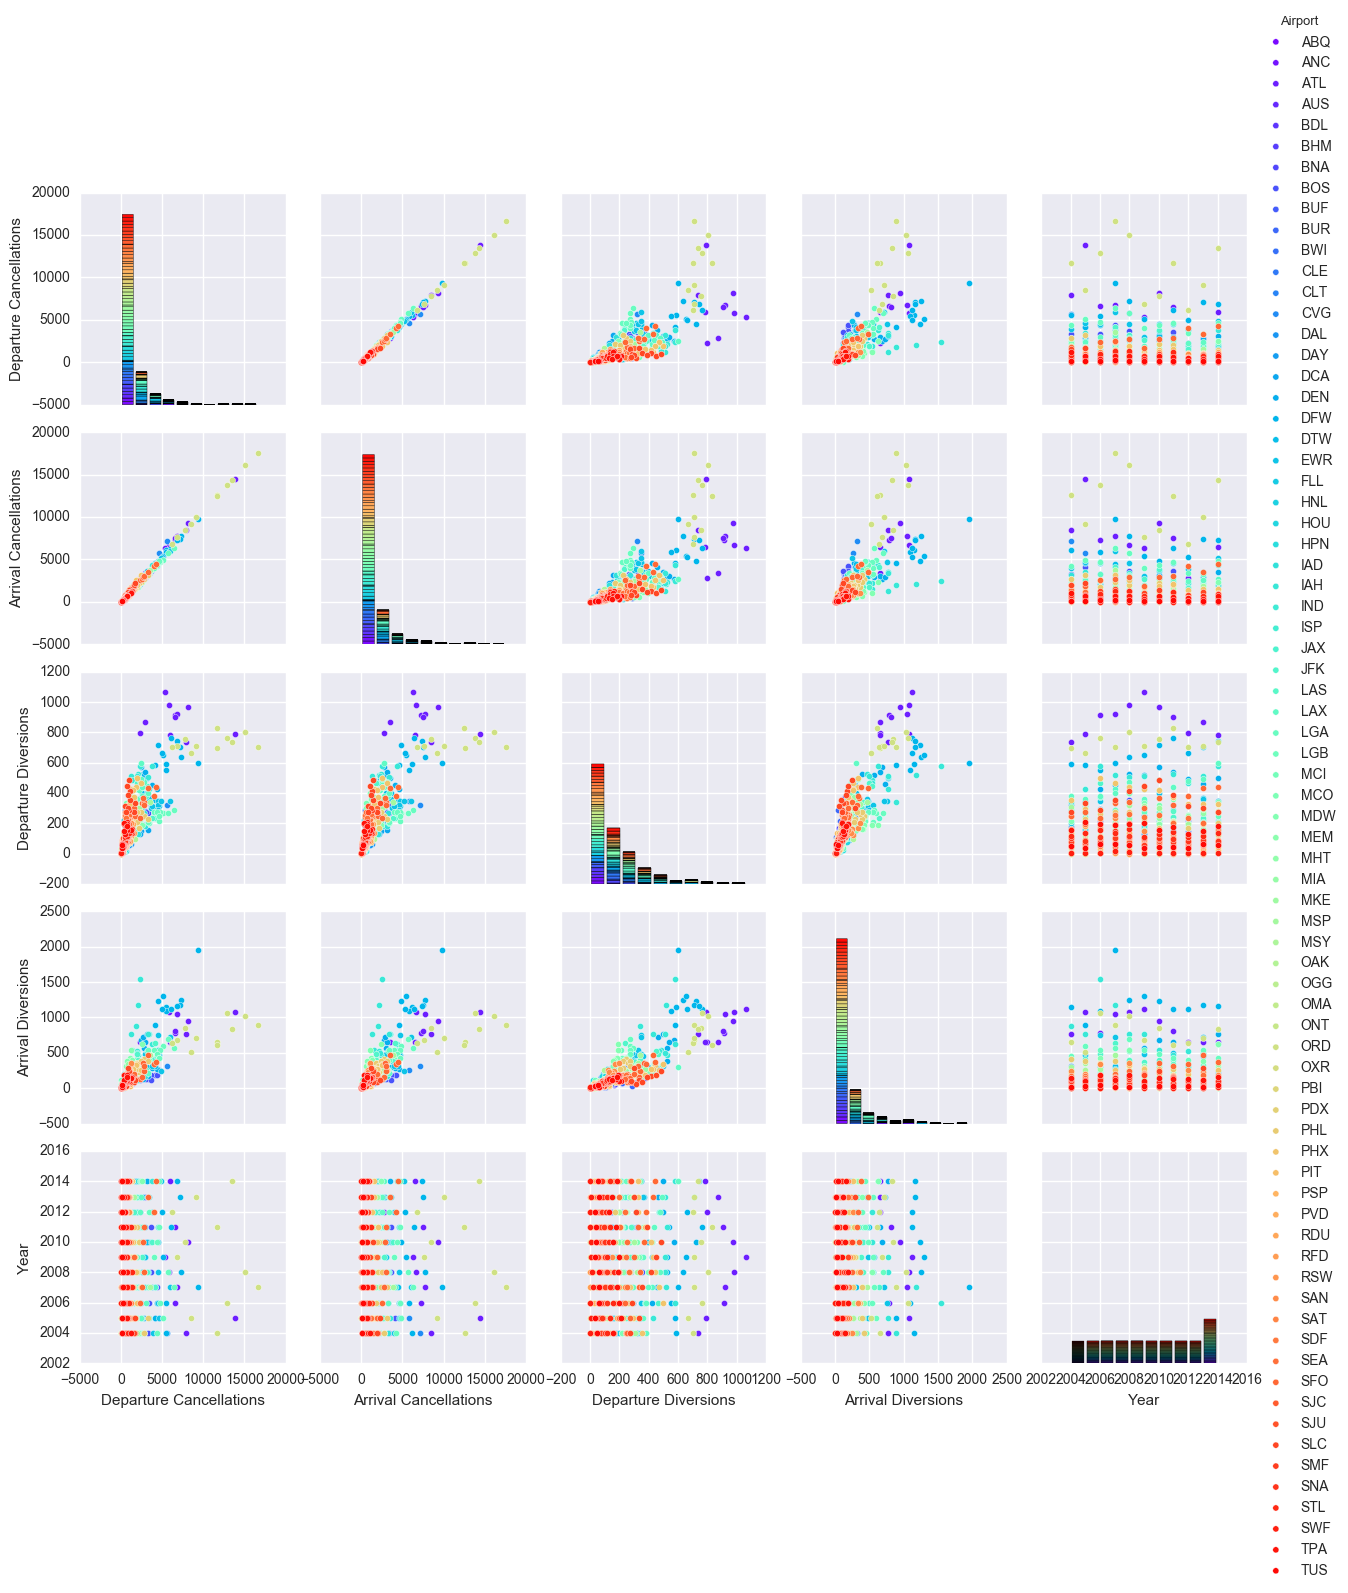

In [13]:
sns.pairplot(cancellations[["Departure Cancellations","Arrival Cancellations",
                            "Departure Diversions","Arrival Diversions","Year","Airport"]],
             hue="Airport", palette = "rainbow")

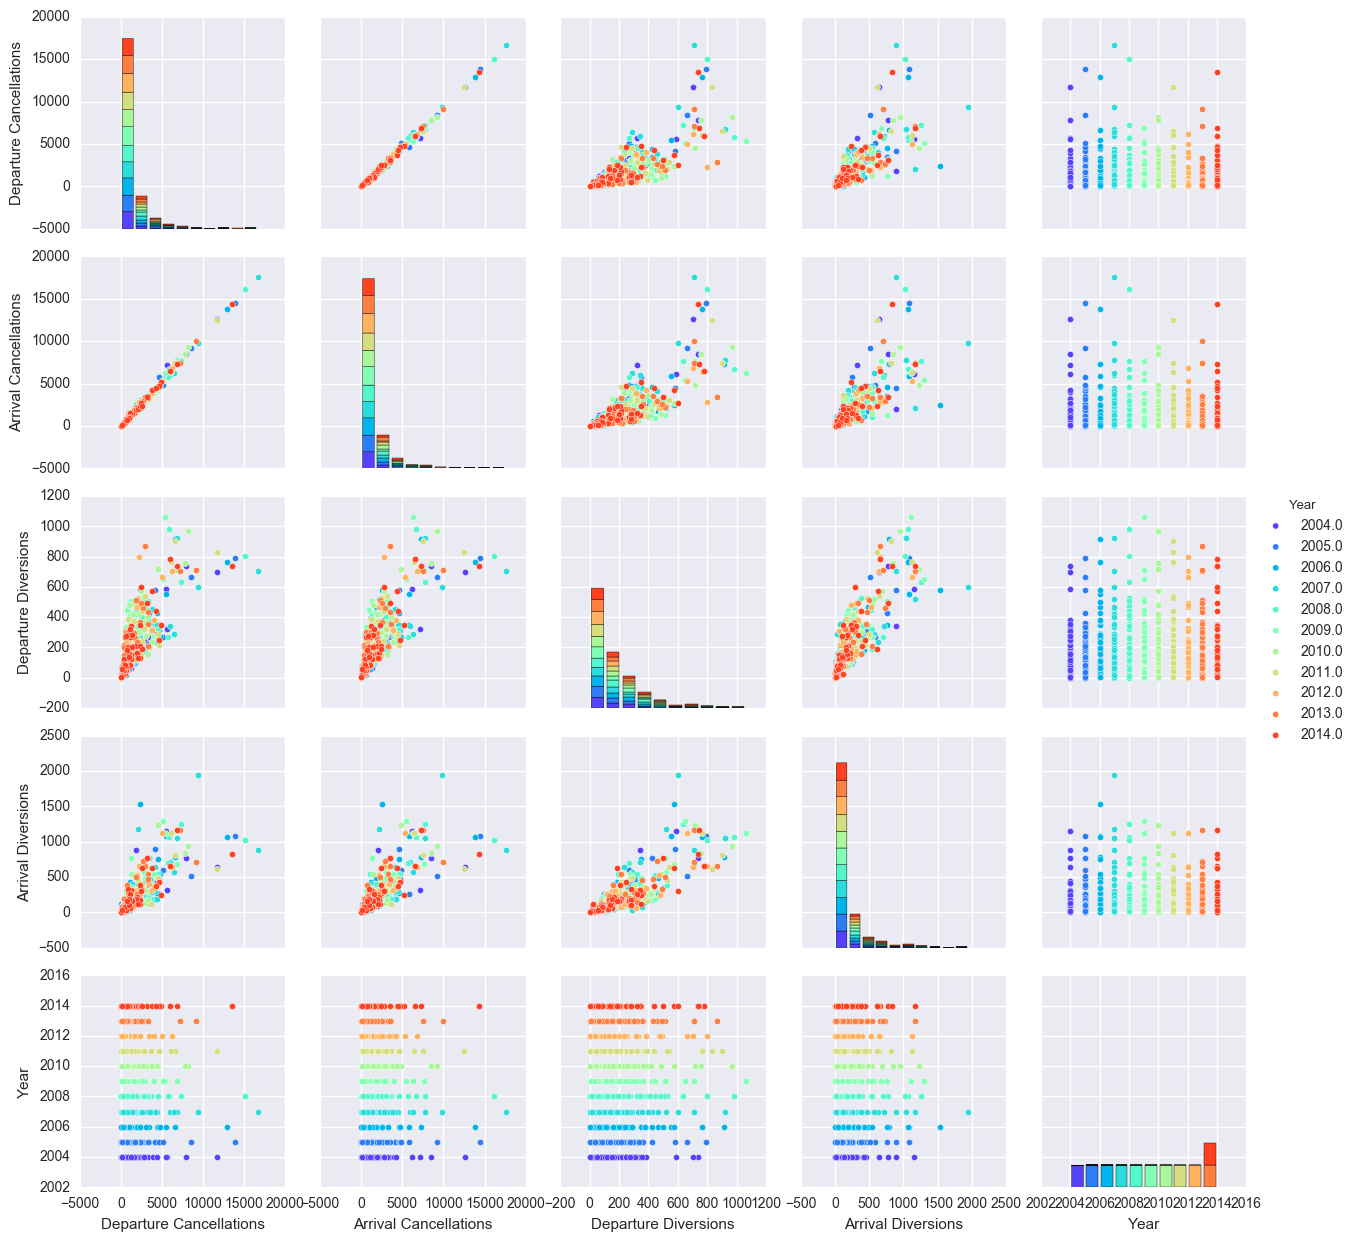

In [14]:
sns.pairplot(cancellations[["Departure Cancellations","Arrival Cancellations",
                            "Departure Diversions","Arrival Diversions","Year"]],
             hue="Year", palette = "rainbow")

### Conclusion from Exploratory Data Analysis

The two airports with particularly bad on-time arrival/departure rates are TEB in New York and VNY in Los Angeles, and these two will be ultimately dropped from the data set before PCA is applied.  the dependence on year seems to be weak, so I will aggregate all data for different years to produce weighted averages for each airport.

In [15]:
operations[operations["percent on-time airport departures"] < 0.4]

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
344,JFK,2007,210060,209898,0.6688,0.3808,0.6298,22.68,35.76,18.94,40.51,6.63,4.01,7.21,24.92
797,TEB,2004,28711,28964,0.2889,0.3104,0.3800,38.41,9.11,0.00,36.89,6.28,0.00,6.09,31.14
798,TEB,2005,29219,29332,0.2945,0.2885,0.3495,37.84,9.44,0.54,38.30,6.23,0.26,7.44,34.28
799,TEB,2006,29286,29520,0.3088,0.3151,0.3598,37.94,10.33,0.05,37.47,5.67,0.00,6.05,32.70
800,TEB,2007,30326,30630,0.2956,0.2951,0.3583,39.86,11.05,0.08,39.90,5.90,0.01,6.58,33.33
801,TEB,2008,26049,25870,0.2786,0.2774,0.3611,38.56,11.20,0.14,38.69,5.69,0.00,6.21,33.41
802,TEB,2009,20989,20866,0.2467,0.2457,0.3979,40.80,11.15,0.10,40.87,5.22,0.00,5.12,31.05
803,TEB,2010,22793,22898,0.2786,0.2767,0.3791,38.17,11.20,0.14,38.31,5.26,0.00,5.15,31.97
804,TEB,2011,24396,24798,0.3185,0.3170,0.3982,35.25,11.16,0.11,35.40,5.39,0.00,5.05,30.94
805,TEB,2012,24396,24778,0.3328,0.3286,0.4084,34.13,11.18,0.13,34.41,4.78,0.00,4.53,30.07


## Data Aggregation

### Weighted Sum

To generate the weighted averages for each airport, the arrival/departure metrics must be multiplied by the appropriate flight volume for each year, then aggregated by year, summing over each column.  The weighted average is then calculated by dividing each column by the total volume.  For the "average block delay" and "average airborne delay" column, which correspond to in-flight time, the appropriate volume value is unclear, so I use the average of arrival and departure volume.  The differences between these two volumes is consistently small enough that this approximation should not meaningfully warp the data.

In [16]:
departures_columns = ["percent on-time gate departures",
                      "percent on-time airport departures",
                      "average_gate_departure_delay",
                      "average_taxi_out_time",
                      "average taxi out delay",
                      "average airport departure delay"]

arrivals_columns = ["percent on-time gate arrivals",
                    "average taxi in delay",
                    "average gate arrival delay"]

flight_columns = ["average block delay","average airborne delay"]

operation_totals = operations.copy()

for col in departures_columns:
    operation_totals[col] = operation_totals[col] * operation_totals["departures for metric computation"]

for col in arrivals_columns:
    operation_totals[col] = operation_totals[col] * operation_totals["arrivals for metric computation"]
    
for col in flight_columns:
    operation_totals[col] = operation_totals[col] * (operation_totals["arrivals for metric computation"] +
                                                     operation_totals["departures for metric computation"]) / 2.

operation_totals = operation_totals.groupby(by="airport").agg('sum').drop('year',axis=1)
operation_totals['airport'] = operation_totals.index
operation_totals.head()

for col in departures_columns:
    operation_totals[col] = operation_totals[col] / operation_totals["departures for metric computation"]

for col in arrivals_columns:
    operation_totals[col] = operation_totals[col] / operation_totals["arrivals for metric computation"]
    
for col in flight_columns:
    operation_totals[col] = operation_totals[col] / (operation_totals["arrivals for metric computation"] +
                                                     operation_totals["departures for metric computation"]) / 2.

operation_totals.head()

,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay,airport
airport,,,,,,,,,,,,,,
ABQ,493135,494420,0.803469,0.777756,0.787651,10.845293,10.180683,2.315451,12.415180,0.477855,0.957070,0.592923,11.251178,ABQ
ANC,743903,695073,0.802442,0.776543,0.787012,14.307178,12.329227,1.917200,15.528576,1.031412,0.546760,1.185455,15.222895,ANC
ATL,5159044,5122886,0.770898,0.631326,0.770570,13.534027,19.798918,7.826810,20.177041,0.825705,3.599842,1.055946,14.607104,ATL
AUS,588016,587668,0.793238,0.769152,0.751284,11.922149,11.614014,2.276690,13.470853,0.530121,1.075103,0.715111,13.988712,AUS
BDL,504934,500302,0.806875,0.764305,0.759987,11.775773,13.089654,3.174204,14.072520,0.722006,0.975630,0.794037,13.781473,BDL


### Pair Plots of Aggregated Operations Data

Considering the aggregated operations data, the two previously-identified outliers are present and more obviously separated from the main group of airport data.  I also drop two other data points which are separated from the main grouping, ultimately dropping all airports with a percentage of one-time gate departures of less than 60%.

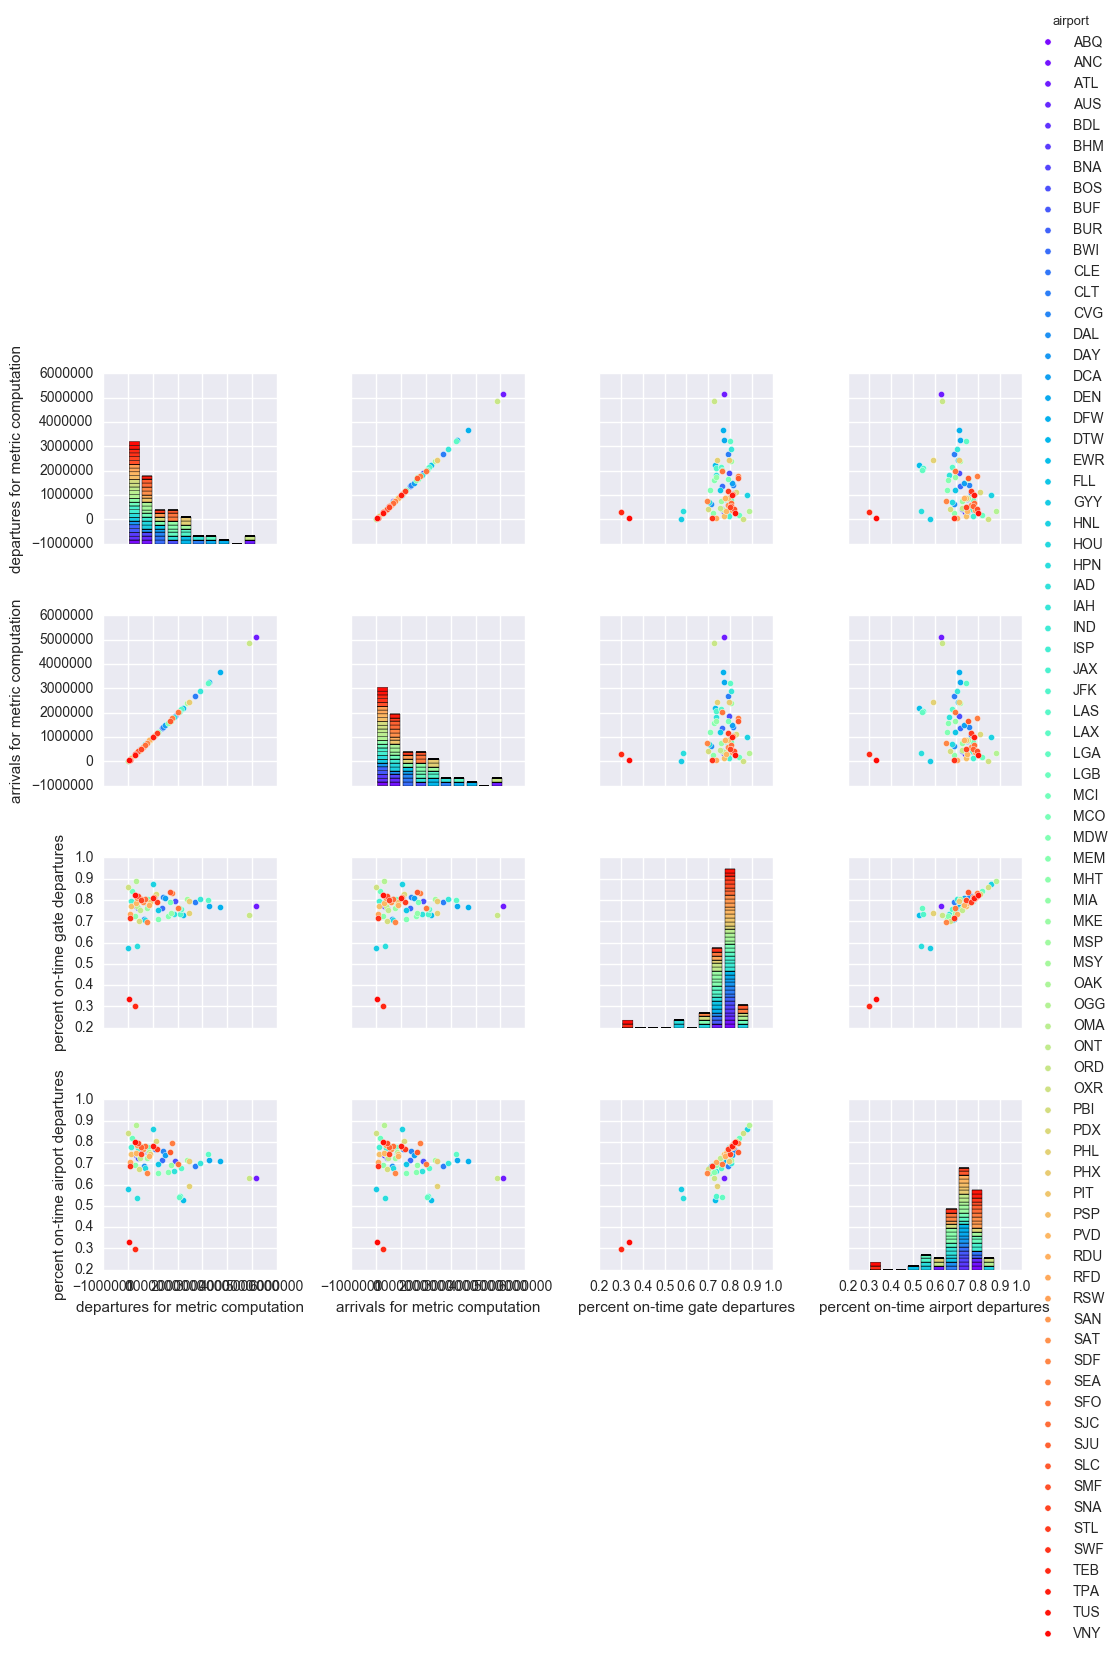

In [17]:
sns.pairplot(operation_totals[["airport","departures for metric computation",
                         "arrivals for metric computation","percent on-time gate departures",
                         "percent on-time airport departures"]],
             hue="airport", palette = "rainbow")

In [18]:
operation_totals = operation_totals[operation_totals["percent on-time gate departures"] > 0.6]

### Inclusion of Cancellation Data

I also include cancellation data, and drop all airports without both operations and cancellation data.  Here I sum the total number of cancellations and diversion for each column in the time period, then divide by the total volume, producing ratios of cancellations or diversions to the total volume of arrivals or departures.

In [19]:
cancellations_total = cancellations.groupby(by="Airport").agg("sum").drop("Year", axis = 1)
cancellations_columns = list(cancellations_total.columns)
cancellations_total['airport'] = cancellations_total.index
cancellations_total.head()

,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,airport
Airport,,,,,
ABQ,3097.0,2658.0,804.0,570.0,ABQ
ANC,3053.0,3750.0,897.0,474.0,ANC
ATL,72186.0,80490.0,9729.0,9594.0,ATL
AUS,5217.0,4738.0,903.0,770.0,AUS
BDL,5603.0,5009.0,732.0,409.0,BDL


In [20]:
totals = delays_by_location = pd.merge(cancellations_total,operation_totals, on="airport",how="inner")
totals['Departure Cancellations'] = totals['Departure Cancellations'] / totals["departures for metric computation"]
totals['Departure Diversions'] = totals['Departure Diversions'] / totals["departures for metric computation"]
totals['Arrival Cancellations'] = totals['Arrival Cancellations'] / totals["arrivals for metric computation"]
totals['Arrival Diversions'] = totals['Arrival Diversions'] / totals["arrivals for metric computation"]

In [21]:
totals.head()

,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,airport,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,0.006280,0.005376,0.001630,0.001153,ABQ,493135,494420,0.803469,0.777756,0.787651,10.845293,10.180683,2.315451,12.415180,0.477855,0.957070,0.592923,11.251178
1,0.004104,0.005395,0.001206,0.000682,ANC,743903,695073,0.802442,0.776543,0.787012,14.307178,12.329227,1.917200,15.528576,1.031412,0.546760,1.185455,15.222895
2,0.013992,0.015712,0.001886,0.001873,ATL,5159044,5122886,0.770898,0.631326,0.770570,13.534027,19.798918,7.826810,20.177041,0.825705,3.599842,1.055946,14.607104
3,0.008872,0.008062,0.001536,0.001310,AUS,588016,587668,0.793238,0.769152,0.751284,11.922149,11.614014,2.276690,13.470853,0.530121,1.075103,0.715111,13.988712
4,0.011096,0.010012,0.001450,0.000818,BDL,504934,500302,0.806875,0.764305,0.759987,11.775773,13.089654,3.174204,14.072520,0.722006,0.975630,0.794037,13.781473


### Overall Aggregation

Finally, I aggregate the processed operations/cancellations data with the latitude and longitude data from the larger list of U.S. airports.

In [22]:
delays_by_location = pd.merge(airports[["LocID","Latitude","Longitude"]],totals, 
                             left_on="LocID",right_on="airport",how="inner")
delays_by_location.drop('LocID', axis=1,inplace=True)
delays_by_location.head()

,Latitude,Longitude,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,airport,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,18.439295,-66.002004,0.005083,0.004472,0.001434,0.000911,SJU,536118,519232,0.805715,0.776878,0.777825,11.713990,13.899512,2.352330,13.162927,0.405079,1.261717,0.875343,13.343954
1,20.898650,-156.430458,0.005187,0.004255,0.000873,0.000833,OGG,331039,325274,0.888906,0.880853,0.865304,7.022367,8.186790,1.270981,7.527449,0.504007,0.844457,0.904527,7.978683
2,21.318681,-157.922429,0.003364,0.003292,0.000504,0.000621,HNL,1009287,1022291,0.876493,0.860543,0.849763,8.065377,12.847434,1.820253,8.943266,0.550739,1.207339,0.900630,9.110357
3,25.795361,-80.290111,0.006075,0.006501,0.001433,0.001273,MIA,1729245,1643044,0.737701,0.691496,0.743835,17.223525,16.178599,3.497457,19.899340,0.621479,2.542084,0.993079,16.175125
4,26.072596,-80.152741,0.006548,0.006383,0.001959,0.001405,FLL,1198908,1188847,0.755182,0.695424,0.749559,15.070012,16.026199,4.253379,18.436436,0.706145,1.126840,0.919644,14.851359


## PCA

### Overall PCA

I perform the overall PCA using all operations data, both on-time percentages and delay information, and keeping the column which explains the most variance.  The results are both explanatory and remarkably interpretable.  The dominant eigenvector explain 63% of the variance in the data set, and is, in rough terms, a weighted difference between the total average number of minutes of delay and the on-time percentage for an airport.  I identify this as the "Delay Factor" for the airport, and will use it in further regression.

In numerical fits below, I consider several variations of this delay factor.  The first uses all data (as shown), a second drops in-flight data, and the last two use only departue and arrival data.  All share the same rough structure in terms of on-time percentages versus length of delay, and more restricted sets of columns have higher explained variance.

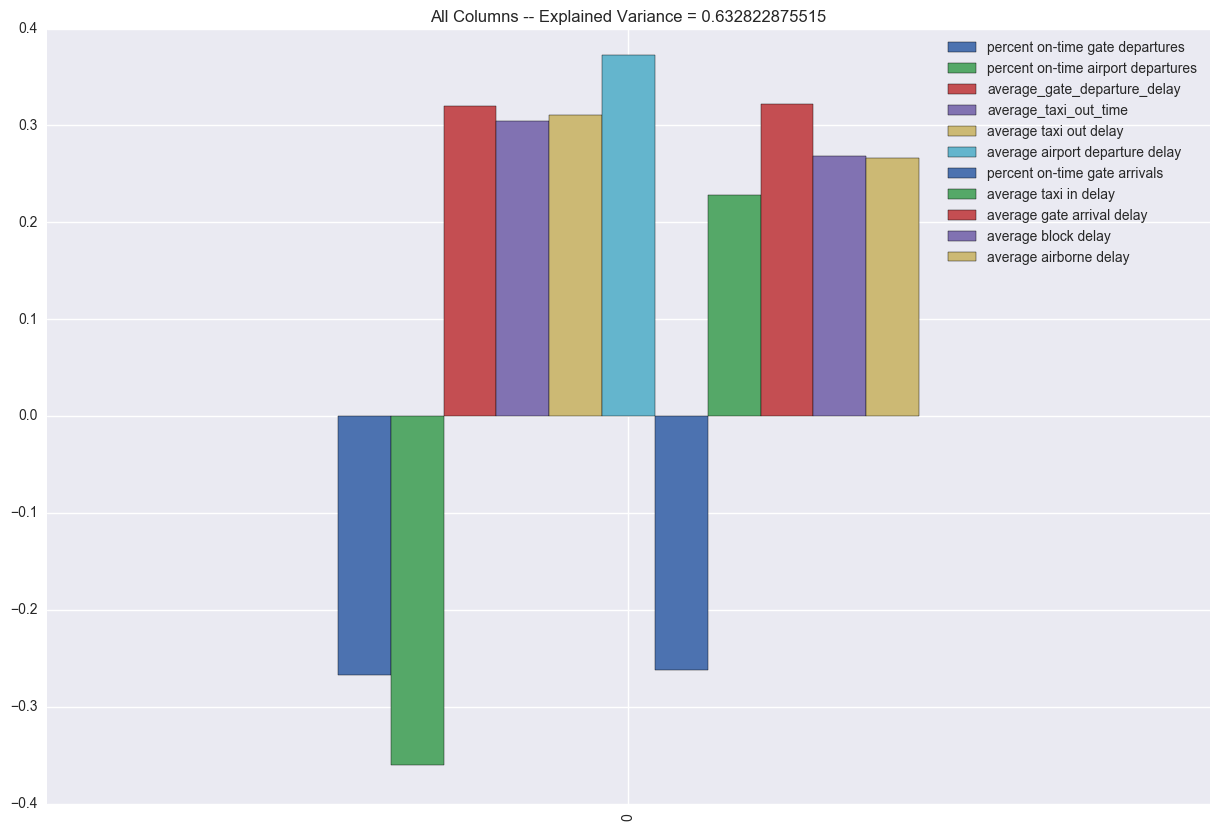

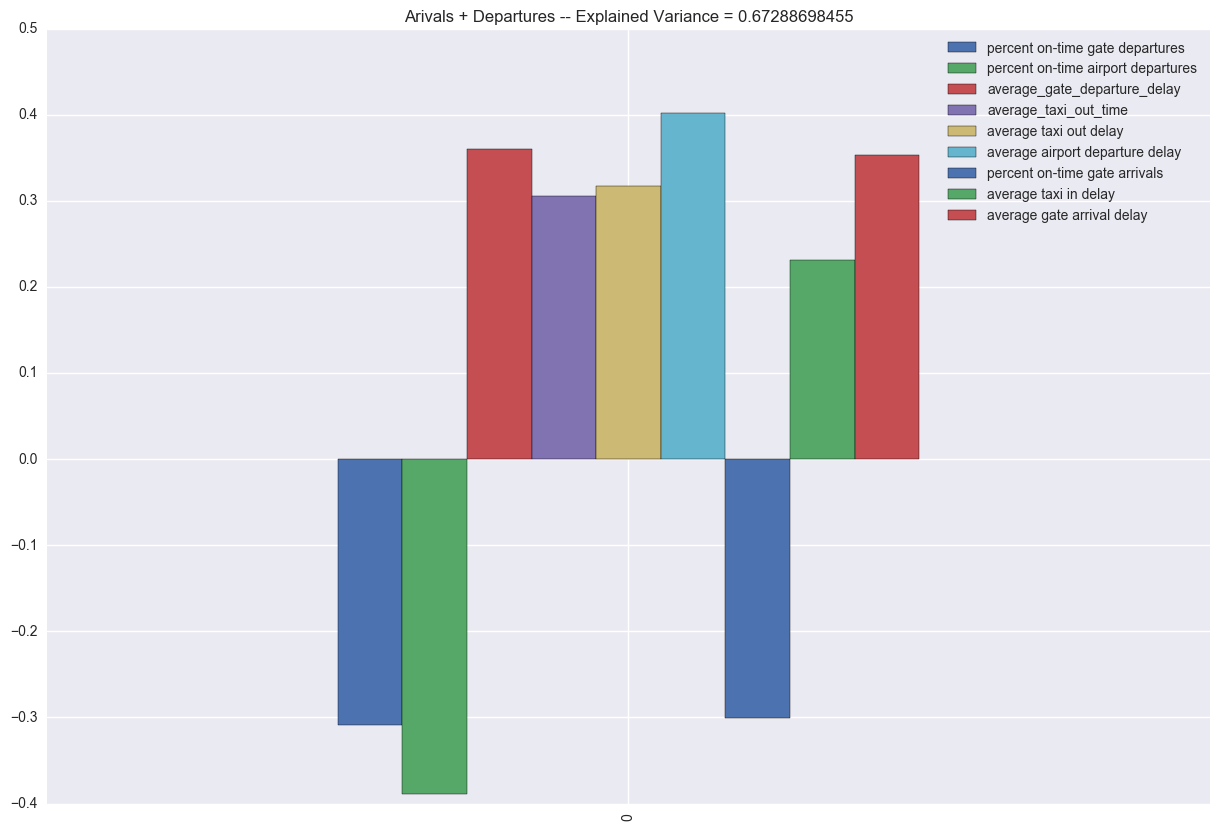

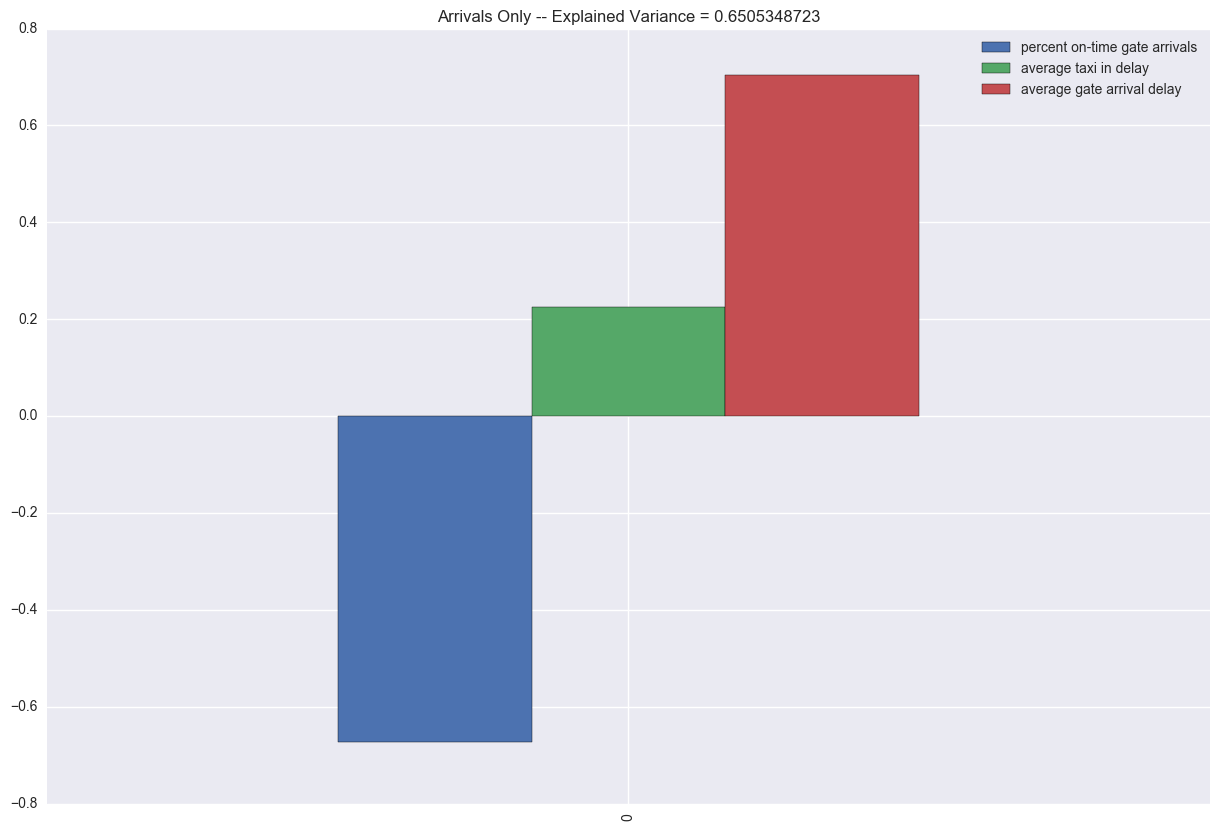

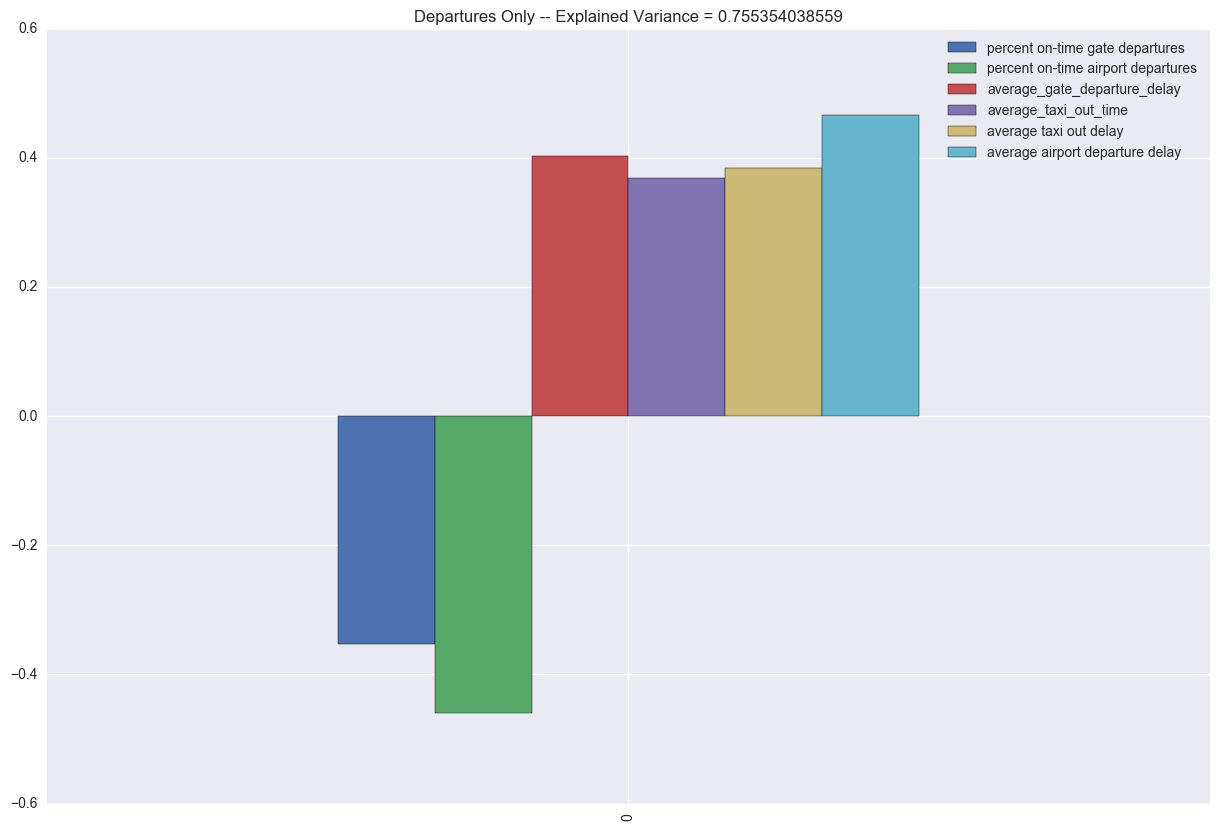

In [23]:
delays_columns = [("All Columns", departures_columns + arrivals_columns + flight_columns),
                  ("Arivals + Departures", departures_columns + arrivals_columns),
                  ("Arrivals Only", arrivals_columns), ("Departures Only", departures_columns)]

for delays in delays_columns:
    operational_delays = delays_by_location[delays[1]]

    pca = PCA(n_components=1)
    scaler = StandardScaler()
    scaled_delays = pd.DataFrame(scaler.fit_transform(operational_delays),columns=operational_delays.columns)
    pca_operations = pd.DataFrame(pca.fit_transform(scaled_delays))

    pd.DataFrame(pca.components_, columns=operational_delays.columns).plot.bar(figsize=(15,10),
                                                                               title= delays[0] + \
                                                                               " -- Explained Variance = "+ \
                                                                               str(pca.explained_variance_ratio_[0]))

### Feature Sets

For the numerical analysis, it is unclear what columns in the available data, if any, correlate with the delay factor generated by PCA. I consider several possible sets of features, combinations of the location, total volume, and cancellation/volume ratios.  

In [25]:
location_columns = ["Latitude","Longitude"]
volume_columns = ["departures for metric computation","arrivals for metric computation"]

features_columns = [("Location", location_columns),
                    ("Volume", volume_columns),
                    ("Cancellations", cancellations_columns),
                    ("Location + Volume", location_columns+volume_columns),
                    ("Location + Cancellations", location_columns+cancellations_columns),
                    ("Volume + Cancellations", volume_columns+cancellations_columns),
                    ("All",location_columns+volume_columns+cancellations_columns)]

### Feature Sets

For the analysis, I consider six regression models with a variety of parameters.  The models are K-Nearest Neighbors, Linear Regression with L2 regularization, SVR, Decision Trees, Random Forest, and Extra Trees, with parameter grids as specified below.  Each model is fit with each feature set and each delay factor defined above. 

In [26]:
model_inputs = []

knn = KNeighborsRegressor()
knn_params = {'n_neighbors':[1,2,3,4,5,10,15,20],'weights':['uniform','distance'],'p':[1,2]}

model_inputs.append(["K-Nearest Neighbors",knn, knn_params])

lr = Ridge()
lr_params = {'alpha':[1e-3,3e-3,1e-2,3e-2,1e-1,3e-1,1,3,10,30,100,300,1000]}

model_inputs.append(["Linear Regression",lr, lr_params])

svc = SVR()
svc_params = {'C':[1e-3,3e-3,1e-2,3e-2,1e-1,3e-1,1,3,10,30,100,300,1000],'kernel':['rbf','sigmoid']}

model_inputs.append(["SVR",svc, svc_params])

dt = DecisionTreeRegressor(min_samples_split=2)
dt_params = {'criterion':['mse','mae'], 'max_features':[None, 'auto', 'sqrt','log2']}

model_inputs.append(["Decision Tree", dt, dt_params])

rf = RandomForestRegressor()
rf_params = {'criterion':['mse','mae'], 'n_estimators':[2,5,10,20,50,100],
             'max_features':[None, 'auto', 'sqrt','log2']}

model_inputs.append(["Random Forest", rf, rf_params])

et = ExtraTreesRegressor()

model_inputs.append(["Extra Trees", et, rf_params])

In [27]:
delays_by_location.head()

,Latitude,Longitude,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,airport,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,18.439295,-66.002004,0.005083,0.004472,0.001434,0.000911,SJU,536118,519232,0.805715,0.776878,0.777825,11.713990,13.899512,2.352330,13.162927,0.405079,1.261717,0.875343,13.343954
1,20.898650,-156.430458,0.005187,0.004255,0.000873,0.000833,OGG,331039,325274,0.888906,0.880853,0.865304,7.022367,8.186790,1.270981,7.527449,0.504007,0.844457,0.904527,7.978683
2,21.318681,-157.922429,0.003364,0.003292,0.000504,0.000621,HNL,1009287,1022291,0.876493,0.860543,0.849763,8.065377,12.847434,1.820253,8.943266,0.550739,1.207339,0.900630,9.110357
3,25.795361,-80.290111,0.006075,0.006501,0.001433,0.001273,MIA,1729245,1643044,0.737701,0.691496,0.743835,17.223525,16.178599,3.497457,19.899340,0.621479,2.542084,0.993079,16.175125
4,26.072596,-80.152741,0.006548,0.006383,0.001959,0.001405,FLL,1198908,1188847,0.755182,0.695424,0.749559,15.070012,16.026199,4.253379,18.436436,0.706145,1.126840,0.919644,14.851359


In [28]:
trained_models = []

pca = PCA(n_components=1)

for features in features_columns:

    print "Feature Columns:",features[0]

    X = delays_by_location[features[1]]

    for delays in delays_columns:

        print "\tDelays Columns:",delays[0]

        operational_delays = delays_by_location[delays[1]]

        scaler = StandardScaler()
        scaled_delays = pd.DataFrame(scaler.fit_transform(operational_delays),columns=operational_delays.columns)
        y = pd.DataFrame(pca.fit_transform(scaled_delays))

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 597)

        scaler_training = StandardScaler()
        X_train = scaler_training.fit_transform(X_train)
        X_test = scaler_training.transform(X_test)

        for model in model_inputs:

            print "\t\tModel:",model[0]

            temp_grid = GridSearchCV(estimator = model[1], cv=5,
                                     scoring='r2', param_grid=model[2])

            temp_grid.fit(X_train, y_train)
            test_pred = temp_grid.best_estimator_.predict(X_test)
            test_score = r2_score(y_test, test_pred)

            
            trained_models.append({"Name":model[0],"Grid":temp_grid,
                                   "Score":temp_grid.best_score_,
                                   "Test Score":test_score,
                                   "Best_Estimator":temp_grid.best_estimator_,
                                   "Features":features[0],"Feature Columns":features[1],
                                   "Delays":delays[0],"Delay Columns":delays[1],
                                   "PCA Explained Variance":pca.explained_variance_ratio_[0]})



models = pd.DataFrame(trained_models)

#print models
display(models[['Features','Delays','Name','Score',"PCA Explained Variance"]])

models.to_pickle("full_model_grid.pkl")



Feature Columns: Location
	Delays Columns: All Columns
		Model: K-Nearest Neighbors
		Model: Linear Regression
		Model: SVR


/Users/dsanford/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


		Model: Decision Tree
		Model: Random Forest


/Users/dsanford/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/dsanford/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_estimator.fit(X, y, **self.fit_params)


		Model: Extra Trees
	Delays Columns: Arivals + Departures
		Model: K-Nearest Neighbors
		Model: Linear Regression
		Model: SVR
		Model: Decision Tree
		Model: Random Forest
		Model: Extra Trees
	Delays Columns: Arrivals Only
		Model: K-Nearest Neighbors
		Model: Linear Regression
		Model: SVR
		Model: Decision Tree
		Model: Random Forest
		Model: Extra Trees
	Delays Columns: Departures Only
		Model: K-Nearest Neighbors
		Model: Linear Regression
		Model: SVR
		Model: Decision Tree
		Model: Random Forest
		Model: Extra Trees
Feature Columns: Volume
	Delays Columns: All Columns
		Model: K-Nearest Neighbors
		Model: Linear Regression
		Model: SVR
		Model: Decision Tree
		Model: Random Forest
		Model: Extra Trees
	Delays Columns: Arivals + Departures
		Model: K-Nearest Neighbors
		Model: Linear Regression
		Model: SVR
		Model: Decision Tree
		Model: Random Forest
		Model: Extra Trees
	Delays Columns: Arrivals Only
		Model: K-Nearest Neighbors
		Model: Linear Regression
		Model: SVR
		Mode

,Features,Delays,Name,Score,PCA Explained Variance
0,Location,All Columns,K-Nearest Neighbors,0.381865,0.632823
1,Location,All Columns,Linear Regression,0.301732,0.632823
2,Location,All Columns,SVR,0.269328,0.632823
3,Location,All Columns,Decision Tree,0.048831,0.632823
4,Location,All Columns,Random Forest,0.318876,0.632823
5,Location,All Columns,Extra Trees,0.315457,0.632823
6,Location,Arivals + Departures,K-Nearest Neighbors,0.409397,0.672887
7,Location,Arivals + Departures,Linear Regression,0.354432,0.672887
8,Location,Arivals + Departures,SVR,0.249091,0.672887
9,Location,Arivals + Departures,Decision Tree,0.002944,0.672887


### Training Set Score

For all the models fit, I output the $R^2$ score for the training set.  The scores have a somewhat normal distribution with a mean of around 0.4 and negative skewness.

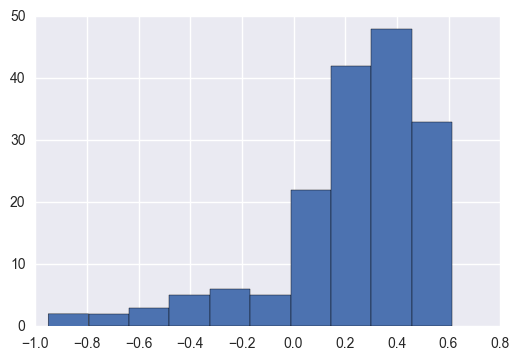

In [29]:
models['Score'].hist()

### Best Model

The best model considered is displayed below, and uses all features through a random forest to predict the departure delay factor.  Its training $R^2$ score is 0.62, but its has a lower test $R^2$ value of 0.26.

In [30]:
max_score = models['Score'].max()

overall_best = models[models['Score'] == max_score]

print "Best model:"
display(overall_best[['Features','Delays','Name','Score','Test Score',"PCA Explained Variance"]])

Best model:


,Features,Delays,Name,Score,Test Score,PCA Explained Variance
94,Location + Volume,Departures Only,Random Forest,0.614298,0.256487,0.755354


### All Test Scores

The test $R^2$ score was poor enough to motivate me to consider the overall distribution of $R^2$ values.  To evaluate overall performance, I examine the test $R^2$ scores for all models.  The results are no encouraging -- like the training scores, they have a roughly normal distribution with negative skewness, but with a mean less than zero.

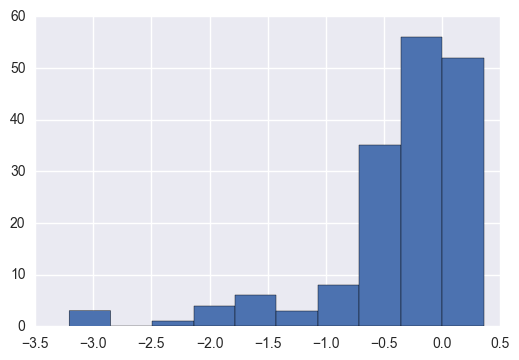

In [31]:
models['Test Score'].hist()

### Average 

Below I show the average test score for each feature set, averaging over model type and delay factor.

In [33]:
display(models[['Features','Score','Test Score']].groupby(by="Features").agg("mean"))

,Score,Test Score
Features,,
All,0.440155,-0.150226
Cancellations,-0.009229,-0.518239
Location,0.276488,-0.829424
Location + Cancellations,0.395211,-0.488384
Location + Volume,0.474473,0.020729
Volume,-0.070383,-0.262843
Volume + Cancellations,0.116628,-0.217856


## Analysis

This project consisted primarily of two parts -- generation of a single "Delay Factor" to characterize airport delay using PCA and attempting to regress on this factor using other available data.

The first aspect generated what appears to be a reasonable single metric for airport delays.  It has the correct behavior in terms of the relative signs of the on-time percentage and individual delay components.  The value of this "Delay Factor" above an ad-hoc metric such as total trip delay is that it mathematically embodies between two-thirds and three-quarters of the variance in the data set depending upon which version is chosen, so it is a better singular metric for the FAA when analyzing delays at airports across the country.

For regression upon the data, the scores on the training set indicates some degree of explanatory power for features in the data set.  Feature sets including location seem to have the strongest average correlation, while volume and cancellation have less correlation.  However, the predictive power of the models is poor.  This is characterized by the test $R^2$ values, which for the models I searched over have a negative $R^2$ values.  This is likely combination of the limited feature set and the small size of the data set, which only includes 73 airports after cuts.

To improve predictive power and better advise the FAA on how to improve airports, more data is required.  Data for more airports would be helpful, but may not be available if most of the large commercial airports in the country are already considered.  But a more diverse feature set, including weather and management data, might provide better predictive power.